<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

### Import Boston housing dataset

In [55]:
from keras.datasets import boston_housing

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

In [15]:
# take a look at the data

print(f'Training data : {X_train.shape}')
print(f'Test data : {X_test.shape}')
print(f'Training sample : {X_test[0]}')
print(f'Training target sample : {y_train[0]}')

Training data : (404, 13)
Test data : (102, 13)
Training sample : [ 18.0846   0.      18.1      0.       0.679    6.434  100.       1.8347
  24.     666.      20.2     27.25    29.05  ]
Training target sample : 15.2


### Standardize data

In [16]:
#calculate the means and standard deviations of features
means = X_train.mean(axis=0)
std = X_train.std(axis=0)

#subtract the means and divide by stddev to standardize
# values now represent # of stddevs from the mean
X_train = X_train - means
X_train = X_train / std

X_test = X_test - means
X_test = X_test / std

### Import model and layers from Keras

In [5]:
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### Instantiate a model object, add layers, and compile

In [11]:
boston_model = Sequential()

In [12]:
# Input --> Hidden
boston_model.add(Dense(16, input_dim=13, activation='relu'))

# Hidden
boston_model.add(Dense(16, activation='relu'))

# Output layer
boston_model.add(Dense(1, activation='linear'))

boston_model.compile(loss='mean_squared_error', 
                     optimizer='adam', 
                     metrics=['mean_squared_error'])

boston_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                224       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = boston_model.fit(X_train, y_train, batch_size=32, epochs=200, validation_split=.1, verbose=0)
scores = boston_model.evaluate(X_test, y_test)
print(f'{boston_model.metrics_names[1]}: {scores[1]*100}')

102/102 [==============================] - 0s 43us/sample - loss: 16.3705 - mean_squared_error: 16.3705
mean_squared_error: 1637.0452880859375


In [23]:
history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

### Plot the model loss from history.history

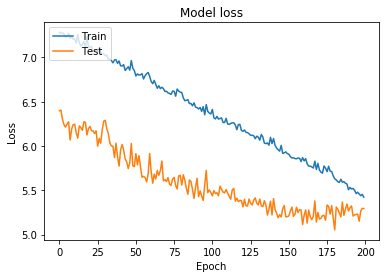

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Linear regression on same data

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
model = LinearRegression()

In [29]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [32]:
y_pred = model.predict(X_test)

### Accuracy comparison

In [33]:
# MSE
# -----------------------------------
# Keras: 16.3705
# LinearRegression: 23.19559925642299

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

23.19559925642299

### Try some feature engineering

In [99]:
from keras.datasets import boston_housing

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

In [100]:
X_train.shape, X_test.shape

((404, 13), (102, 13))

In [101]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.transform(X_test)

In [102]:
poly_X_train.shape, poly_X_test.shape

((404, 104), (102, 104))

### Check which model sees a greater accuracy boost

In [106]:
poly_boston_model = Sequential()

In [107]:
# Input --> Hidden
poly_boston_model.add(Dense(16, input_dim=104, activation='relu'))

# Hidden
poly_boston_model.add(Dense(16, activation='relu'))

# Output layer
poly_boston_model.add(Dense(1, activation='linear'))

poly_boston_model.compile(loss='mean_squared_error', 
                     optimizer='adam', 
                     metrics=['mean_squared_error'])

poly_boston_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 16)                1680      
_________________________________________________________________
dense_31 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 17        
Total params: 1,969
Trainable params: 1,969
Non-trainable params: 0
_________________________________________________________________


In [108]:
history = poly_boston_model.fit(poly_X_train, y_train, batch_size=32, epochs=200, validation_split=.1, verbose=0)
scores = poly_boston_model.evaluate(poly_X_test, y_test)
print(f'{poly_boston_model.metrics_names[1]}: {scores[1]*100}')

102/102 [==============================] - 0s 51us/sample - loss: 87570.9116 - mean_squared_error: 87570.9141
mean_squared_error: 8757091.40625


In [109]:
y_train.shape

(404,)

In [110]:
poly_model = LinearRegression()
poly_model.fit(poly_X_train, y_train)
poly_y_pred = poly_model.predict(poly_X_test)

In [111]:
# When adding polynomial features, the neural network got much worse, 
# and the linear regression got better
mean_squared_error(y_test, poly_y_pred)

10.6475747362145

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [125]:
from keras.datasets import fashion_mnist
((X_train, y_train), (X_test, y_test)) = fashion_mnist.load_data()

In [126]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [127]:
# Reshape the data into single vectors
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [128]:
# X Variable Types
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

### One hot encode category labels

In [129]:
# Correct encoding of y
# What softmax expects = [0,0,0,0,0,1,0,0,0,0]

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [130]:
fashion_model = Sequential()

# Input -> Hidden (or input shape = (784,))
fashion_model.add(Dense(16, input_dim=784, activation='relu'))

#Hidden
fashion_model.add(Dense(16, activation='relu'))

# Output Layer
fashion_model.add(Dense(10, activation='softmax'))

fashion_model.compile(loss='categorical_crossentropy',
                    optimizer='adam', 
                    metrics=['accuracy'])
fashion_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_37 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_38 (Dense)             (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [132]:
history = fashion_model.fit(X_train, y_train, batch_size=50000, 
                            epochs=1000, validation_split=.1, verbose=1)
scores = fashion_model.evaluate(X_test, y_test)
print(f'{fashion_model.metrics_names[1]}: {scores[1]*100}')

Train on 54000 samples, validate on 6000 samples
Epoch 1/1000
54000/54000 [==============================] - 1s 10us/sample - loss: 0.3663 - acc: 0.8635 - val_loss: 0.6241 - val_acc: 0.8257
Epoch 2/1000
54000/54000 [==============================] - 0s 9us/sample - loss: 0.3650 - acc: 0.8641 - val_loss: 0.6302 - val_acc: 0.8257
Epoch 3/1000
54000/54000 [==============================] - 0s 9us/sample - loss: 0.3648 - acc: 0.8638 - val_loss: 0.6323 - val_acc: 0.8257
Epoch 4/1000
54000/54000 [==============================] - 0s 9us/sample - loss: 0.3635 - acc: 0.8642 - val_loss: 0.6316 - val_acc: 0.8238
Epoch 5/1000
54000/54000 [==============================] - 1s 12us/sample - loss: 0.3647 - acc: 0.8636 - val_loss: 0.6264 - val_acc: 0.8225
Epoch 6/1000
54000/54000 [==============================] - 1s 10us/sample - loss: 0.3662 - acc: 0.8638 - val_loss: 0.6294 - val_acc: 0.8253
Epoch 7/1000
54000/54000 [==============================] - 0s 9us/sample - loss: 0.3670 - acc: 0.8643 - val

Epoch 200/200
54000/54000 [==============================] - 9s 160us/sample - loss: 0.8561 - acc: 0.6486 - val_loss: 0.9132 - val_acc: 0.6383

In [124]:
history2 = fashion_model.fit(X_train, y_train, batch_size=10000, 
                            epochs=500, validation_split=.1, verbose=1)
scores2 = fashion_model.evaluate(X_test, y_test)
print(f'{fashion_model.metrics_names[1]}: {scores[1]*100}')

Train on 54000 samples, validate on 6000 samples
Epoch 1/500
54000/54000 [==============================] - 1s 22us/sample - loss: 0.8073 - acc: 0.6575 - val_loss: 0.8948 - val_acc: 0.6417
Epoch 2/500
54000/54000 [==============================] - 1s 14us/sample - loss: 0.8065 - acc: 0.6576 - val_loss: 0.8947 - val_acc: 0.6407
Epoch 3/500
54000/54000 [==============================] - 1s 11us/sample - loss: 0.8065 - acc: 0.6578 - val_loss: 0.8928 - val_acc: 0.6412
Epoch 4/500
54000/54000 [==============================] - 1s 9us/sample - loss: 0.8051 - acc: 0.6582 - val_loss: 0.8947 - val_acc: 0.6413
Epoch 5/500
54000/54000 [==============================] - 1s 11us/sample - loss: 0.8049 - acc: 0.6581 - val_loss: 0.8943 - val_acc: 0.6417
Epoch 6/500
54000/54000 [==============================] - 1s 10us/sample - loss: 0.8042 - acc: 0.6583 - val_loss: 0.8935 - val_acc: 0.6412
Epoch 7/500
54000/54000 [==============================] - 1s 11us/sample - loss: 0.8036 - acc: 0.6583 - val_los

In [ ]:
# for some reason on Will's machine this same code was getting ~.79
# consistently across different parameter values

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.